In [1]:
from landlab import RasterModelGrid
from gravel_bedrock_eroder.gravel_bedrock_eroder import GravelBedrockEroder
from landlab.components import FlowAccumulator
from ClastGrading import ClastGrading
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# Global parameters
porosity = 0.4                              # [-]
soil_density = 2650                         # [kg/m^3]
initial_sediment_weight_at_node = 100000    # [kg]
n_steps = 500

""" Create grading features with different fragmentation models. 
Fragmentation models are describe by the following string:
      !!   pX-AAA-BBB-CCC-DDD'  !!       
while
X = number of daughter particles
AAA = weight % that *REMAINS* in  parent after fragmentation
BBB / CCC / DDD ... = proportion of daughters '
"""
grading_name = 'p2-0-100'  # ,'p2-10-10-spread'  #,'p2-0-100'

In [3]:
# Create grid
grid = RasterModelGrid((3, 3), xy_spacing=1000.0)
elev = grid.add_zeros("topographic__elevation", at="node")

In [4]:
# Flag for an apriori grain size disribution OR for generating a distribution
known_dist_flag = True

if known_dist_flag:
    mean_grainsize_per_class = [0.002, 0.02, 0.2, 2, 10]  # [0.002, 0.2, 1 ]  # [m]
    init_median_grainsize_at_node = 0.2           # [m]
    n_size_classes = np.size(mean_grainsize_per_class )
    A_factor = 0.001
else:
    init_median_grainsize_at_node = 0.1           # [m]
    n_size_classes = 30
    maxsize = 2
    A_factor = 0.01

In [5]:
# Call ClastGrading component
grading = ClastGrading(
    grid,
    grading_name=grading_name,
    n_size_classes=n_size_classes,
    clast_density=soil_density,
    phi=porosity,
)

In [6]:
if known_dist_flag:
    grading.set_grading_classes(input_sizes_flag=True,
                                meansizes=mean_grainsize_per_class,
                                )
    grading.create_transition_mat(A_factor=A_factor)
    
    # Create grain size distribution for initial debris layer
    grading.create_dist(
        median_size=init_median_grainsize_at_node,
        num_of_clasts=initial_sediment_weight_at_node,
        init_val_flag=True,
    std=1)

else:

    grading.set_grading_classes(maxsize = maxsize)
    grading.create_transion_mat(A_factor=A_factor)
    # Create grain size distribution for initial debris layer
    grading.create_dist(
        median_size=init_median_grainsize_at_node,
        num_of_clasts=initial_sediment_weight_at_node,
        init_val_flag=True, )

In [7]:
grid.at_node['soil__depth']

array([  6.28930818e-05,   6.28930818e-05,   6.28930818e-05,
         6.28930818e-05,   6.28930818e-05,   6.28930818e-05,
         6.28930818e-05,   6.28930818e-05,   6.28930818e-05])

In [8]:
# Call other components 
fa = FlowAccumulator(grid, runoff_rate=10.0)
fa.run_one_step()
eroder = GravelBedrockEroder(
    grid, sediment_porosity = 0.4, abrasion_coefficients = [0.0005]
)

In [9]:
# Boundary conditions
grid.status_at_node[grid.perimeter_nodes] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[5] = grid.BC_NODE_IS_FIXED_VALUE

In [10]:
# Pointers
rock_elev = grid.at_node["bedrock__elevation"]

# save inital weight per grain size
init_weight_per_grainsize = np.copy(grid.at_node['grain__weight'][3,:])

In [11]:
# MAIN LOOP
for _ in range(n_steps ):
    rock_elev[grid.core_nodes] += 1.0
    elev[grid.core_nodes] += 1.0
    fa.run_one_step()
    eroder.run_one_step(10000.0)
    grading.run_one_step()

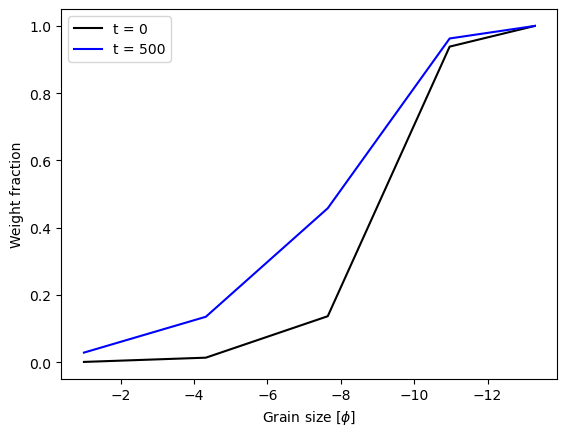

In [12]:
# Figure
total_weight = np.sum(grid.at_node['grain__weight'][3,:])
fig,ax = plt.subplots(1,1)
ax.plot(-np.log2(grading._meansizes*1000),
        np.cumsum(init_weight_per_grainsize)/total_weight,
        color='black',
       label='t = 0')
ax.plot(-np.log2(grading._meansizes*1000),np.cumsum(grid.at_node['grain__weight'][3,:])/total_weight,color='blue',label='t = ' + str(n_steps ))
ax.set_xlabel('Grain size [$\phi$]')
ax.set_ylabel('Weight fraction')
ax.invert_xaxis() # phi scale
ax.legend()
plt.show()

In [48]:
init_weight_per_grainsize

array([  6.77000000e+02,   1.93000000e+02,   2.03000000e+02,
         2.72000000e+02,   3.28000000e+02,   5.23000000e+02,
         6.59000000e+02,   7.68000000e+02,   9.26000000e+02,
         1.35400000e+03,   1.79300000e+03,   2.41500000e+03,
         3.22200000e+03,   4.59800000e+03,   6.26200000e+03,
         8.56000000e+03,   1.12300000e+04,   1.40900000e+04,
         1.56670000e+04,   1.40680000e+04,   8.77900000e+03,
         2.99600000e+03,   4.03000000e+02,   1.40000000e+01,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00])

In [37]:
grading.update_sizes()

In [70]:
## Let say you have a transition matrix A.
# A dims are number_of_grain_size_classes X number_of_grain_size_classes
np.shape(grading._A)

(30, 30)

In [107]:
# Each node 
n_of_grainsize_classes = 5

a = np.reshape(
    np.dot(
        grading._A,
          np.swapaxes(
              np.reshape(
                  grid.at_node['grain__weight'],
                                 (grid.shape[0],grid.shape[1],n_of_grainsize_classes))
              ,1,2)
                    ),
              (grid.shape[0]*grid.shape[1],n_of_grainsize_classes)
)


In [125]:
_n_sizes = 5
a = np.moveaxis(np.dot(grading._A , np.swapaxes(
            np.reshape(grid.at_node['grain__weight'], (grid.shape[0],
                                                            grid.shape[1],
                                                            _n_sizes)), 1,
            2)),
                                    0, -1)

In [128]:
np.reshape(a, (grid.shape[0] * grid.shape[1], _n_sizes))

array([[  1212.,  11087.,  67803., -73836.,  -6266.],
       [  1212.,  11087.,  67803., -73836.,  -6266.],
       [  1212.,  11087.,  67803., -73836.,  -6266.],
       [  1212.,  11087.,  67803., -73836.,  -6266.],
       [  1212.,  11087.,  67803., -73836.,  -6266.],
       [  1212.,  11087.,  67803., -73836.,  -6266.],
       [  1212.,  11087.,  67803., -73836.,  -6266.],
       [  1212.,  11087.,  67803., -73836.,  -6266.],
       [  1212.,  11087.,  67803., -73836.,  -6266.]])

In [129]:
grading._A

array([[ 0.,  1.,  0.,  0.,  0.],
       [ 0., -1.,  1.,  0.,  0.],
       [ 0.,  0., -1.,  1.,  0.],
       [ 0.,  0.,  0., -1.,  1.],
       [ 0.,  0.,  0.,  0., -1.]])

In [130]:
grid.at_node['grain__weight']

array([[   121.,   1212.,  12299.,  80102.,   6266.],
       [   121.,   1212.,  12299.,  80102.,   6266.],
       [   121.,   1212.,  12299.,  80102.,   6266.],
       [   121.,   1212.,  12299.,  80102.,   6266.],
       [   121.,   1212.,  12299.,  80102.,   6266.],
       [   121.,   1212.,  12299.,  80102.,   6266.],
       [   121.,   1212.,  12299.,  80102.,   6266.],
       [   121.,   1212.,  12299.,  80102.,   6266.],
       [   121.,   1212.,  12299.,  80102.,   6266.]])

In [81]:
b = np.moveaxis(a,0,-1)
np.shape(b)

(3, 3, 30)

In [82]:
kk = np.reshape(b,(grid.shape[0]*grid.shape[1],30))

In [83]:
np.shape(k)

(9, 30)

In [84]:
k -kk

array([[  0.00000000e+00,   1.42000000e+02,   1.13000000e+02,
          1.40000000e+02,   5.70000000e+01,   5.70000000e+01,
         -4.00000000e+00,  -7.30000000e+01,  -1.21000000e+02,
         -4.28000000e+02,  -5.77000000e+02,  -8.90000000e+02,
         -1.16700000e+03,  -1.53500000e+03,  -2.33400000e+03,
         -3.08700000e+03,  -2.56100000e+03,  -1.49300000e+03,
          1.65900000e+03,   5.41600000e+03,   5.95800000e+03,
          2.59600000e+03,   4.64000000e+02,   7.90000000e+01,
          7.00000000e+01,   6.90000000e+01,   6.90000000e+01,
          4.20000000e+01,   4.20000000e+01,   4.20000000e+01],
       [ -1.40000000e+02,   2.00000000e+00,  -2.70000000e+01,
          0.00000000e+00,  -8.30000000e+01,  -8.30000000e+01,
         -6.10000000e+01,  -1.30000000e+02,  -1.78000000e+02,
         -3.43000000e+02,  -4.92000000e+02,  -8.05000000e+02,
         -1.08200000e+03,  -1.45000000e+03,  -2.24900000e+03,
         -3.00200000e+03,  -2.47600000e+03,  -1.40800000e+03,
       

In [117]:
grading._A

array([[ 0.,  1.,  0.,  0.,  0.],
       [ 0., -1.,  1.,  0.,  0.],
       [ 0.,  0., -1.,  1.,  0.],
       [ 0.,  0.,  0., -1.,  1.],
       [ 0.,  0.,  0.,  0., -1.]])

In [1]:
from landlab import RasterModelGrid
from SoilGrading import SoilGrading
from matplotlib import pyplot as plt
import numpy as np

In [2]:
## Unit test 1
grid = RasterModelGrid((3, 3), xy_spacing=1.0)
soil_grading = SoilGrading(grid)
grid.at_node['soil__depth'][1] == (np.sum(grid.at_node['grains__weight'][1]) / (grid.dx*grid.dy * soil_grading._soil_density * (1-soil_grading._phi)))

True

In [3]:
grid = RasterModelGrid((3, 3), xy_spacing=1.0)
grid.add_field("soil__depth", np.zeros((grid.shape[0], grid.shape[1])), at="node", dtype=float)
soil_grading = SoilGrading(grid)
warning.

ValueError: Soil field already existed

In [2]:
## Unit test 1
grid = RasterModelGrid((3, 3), xy_spacing=1.0)
soil_grading = SoilGrading(grid)
(np.sum(grid.at_node['bed_grains__proportions'][1])-1)<10**-10

True

In [3]:
## Unit test 2
grid = RasterModelGrid((3, 3), xy_spacing=1.0)
meansizes=[0.001, 0.01, 0.1]
soil_grading = SoilGrading(grid, meansizes = meansizes, initial_median_size=0.01)
np.all(grid.at_node['grains_fractions__size'][0] == meansizes)

True

In [4]:
## Unit test 3
grid = RasterModelGrid((3, 3), xy_spacing=1.0)
meansizes=[0.001, 0.01, 0.1]
initial_median_size = -np.inf
soil_grading = SoilGrading(grid, meansizes = meansizes, initial_median_size=initial_median_size)
soil_grading.create_dist(is_bedrock_distribution_flag=True, median_size = initial_median_size )
grid.at_node['bed_grains__proportions'][1][0] == 1

/Users/yush9908/Dropbox/Mac/Documents/GravelBed/GravelBed_code/SoilGrading.py:332: UserWarning: Median size provided is smaller than the distribution lower bound
  warnings.warn("Median size provided is smaller than the distribution lower bound")


True

In [5]:
## Unit test 4
grid = RasterModelGrid((3, 3), xy_spacing=1.0)
meansizes=[0.001, 0.01, 0.1]
initial_median_size = np.inf
soil_grading = SoilGrading(grid, meansizes = meansizes, initial_median_size=initial_median_size)
soil_grading.create_dist(is_bedrock_distribution_flag=True, median_size = initial_median_size )
grid.at_node['bed_grains__proportions'][1][-1] == 1

/Users/yush9908/Dropbox/Mac/Documents/GravelBed/GravelBed_code/SoilGrading.py:337: UserWarning: Median size provided is larger than the distribution upper bound
  warnings.warn("Median size provided is larger than the distribution upper bound")


True

In [6]:
## Unit test 5
grid = RasterModelGrid((3, 3), xy_spacing=1.0)
meansizes=[0.001, 0.01, 0.1]
initial_median_size = 0.01
soil_grading = SoilGrading(grid, meansizes = meansizes, initial_median_size=initial_median_size)
grid.at_node['median_size__weight'][0] == initial_median_size

True

True

array([ 890.,  861.,  636.,  227.,   35.,    1.,    0.,    0.,    0.,    0.])

In [6]:
for _ in range(1000):
    soil_grading.run_one_step()

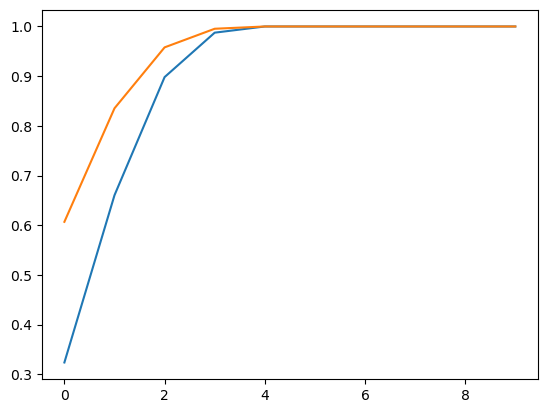

In [7]:
gt = np.copy(grid.at_node['grains__weight'][grid.nodes][1,1])
plt.plot(np.cumsum(g0/np.sum(g0)))
plt.plot(np.cumsum(gt/np.sum(gt)))

In [8]:
soil_grading.create_dist(is_bedrock_distribution_flag=True, median_size = 2)

size of =  (11,)


/Users/yush9908/Dropbox/Mac/Documents/GravelBed/GravelBed_code/SoilGrading.py:327: UserWarning: Median size provided is larger than the distribution upper bound
  warnings.warn("Median size provided is larger than the distribution upper bound")


In [9]:
grid.at_node['bed_grains__proportions'][2]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.])

In [30]:
soil_grading._std

0.6

In [75]:
import scipy.stats as stats

median_size = 100000
lower= 0.001
upper = 0.01
std = median_size*0.001
b = stats.truncnorm(
            (lower - median_size) / std, (upper - median_size) / std, loc = median_size, scale = std)

In [102]:
import warnings
total_soil_weight = 10000
median_size = 0.005
std = median_size*0.6
values = []
if median_size < lower:
    grains_weight__distribution  = np.zeros_like(np.insert(soil_grading._upperlims, 0, 0))
    grains_weight__distribution[0] = total_soil_weight
    warnings.warn("Median size provided is smaller than the distribution lower bound")

elif median_size > upper:
    grains_weight__distribution  = np.zeros_like(np.insert(soil_grading._upperlims, 0, 0))
    grains_weight__distribution[-1] = total_soil_weight
    warnings.warn("Median size provided is larger than the distribution upper bound")

else:
    while np.size(values) < total_soil_weight:
        sample = random.gauss(median_size, std)
        if sample >= lower and sample <= upper:
            values.append(sample)

    grains_weight__distribution = np.histogram(values, np.insert(soil_grading._upperlims, 0, 0))[0]

np.sum(grains_weight__distribution)

10000

In [86]:
grains_weight__distribution

array([1287,  741, 1078, 1535, 1955, 2013, 1391,    0,    0,    0])

In [88]:
soil_grading._upperlims

array([ 0.0025    ,  0.0031498 ,  0.0039685 ,  0.005     ,  0.00629961,
        0.00793701,  0.01      ,  0.01259921,  0.01587401,  0.02      ])

In [30]:
soil_grading._upperlims

array([ 0.0025    ,  0.0031498 ,  0.0039685 ,  0.005     ,  0.00629961,
        0.00793701,  0.01      ,  0.01259921,  0.01587401,  0.02      ])

In [13]:
np.shape(grid.at_node['bed_grains__proportions'])

(9, 10)

In [11]:
soil_grading.g_state0

array([843, 925, 631, 229,  21,   1,   0,   0,   0,   0])

In [16]:
np.shape(np.divide(soil_grading.g_state_bedrock, np.sum(soil_grading.g_state_bedrock)))

(11,)

In [24]:
np.shape(soil_grading.g_state_bedrock)

(11,)

In [17]:
from numpy import testing


In [25]:

err_msg = "Wrong proportion of grains fractions in bedrock"
n_rows = 5
n_columns = 5
spacing = 1
meansizes = [0.001, 0.01, 0.1]
initial_median_size_soil = 0.01

mg = RasterModelGrid((n_rows, n_columns), xy_spacing=spacing)
median_size_bedrock = -np.inf

soil_grading = SoilGrading(mg, meansizes=meansizes, initial_median_size=initial_median_size_soil)
soil_grading.create_dist(is_bedrock_distribution_flag=True, median_size=median_size_bedrock)
proportion_of_mass_in_the_larger_size_fraction = mg.at_node['bed_grains__proportions'][9,0]

testing.assert_approx_equal(proportion_of_mass_in_the_larger_size_fraction, 1,
                            err_msg=err_msg)

In [23]:
np.shape(grid.at_node['bed_grains__proportions'])


(9, 10)

In [26]:
mg.at_node['bed_grains__proportions'][9,0]

1.0

In [1]:
import test_soil_grading

In [2]:
test_soil_grading.test_outputFields_soil()
test_soil_grading.test_inputFields_soil()
test_soil_grading.test_outputFields_bedrock()
test_soil_grading.test_inputFields_topographic_elevation()
test_soil_grading.test_depth_and_grains_mass_match()
test_soil_grading.test_bedrock_grains_proportions()
test_soil_grading.test_match_to_user_defined_median_size()
test_soil_grading.test_match_to_user_defined_meansizes()
test_soil_grading.test_beyond_range_user_defined_soil_median_size_larger()
test_soil_grading.test_beyond_range_user_defined_bedrock_median_size_larger()
test_soil_grading.test_beyond_range_user_defined_soil_median_size_smaller()
test_soil_grading.test_beyond_range_user_defined_bedrock_median_size_smaller()

/Users/yush9908/Dropbox/Mac/Documents/GravelBed/GravelBed_code/SoilGrading.py:321: UserWarning: Median size provided is larger than the distribution upper bound
  warnings.warn("Median size provided is larger than the distribution upper bound")
/Users/yush9908/Dropbox/Mac/Documents/GravelBed/GravelBed_code/SoilGrading.py:316: UserWarning: Median size provided is smaller than the distribution lower bound
  warnings.warn("Median size provided is smaller than the distribution lower bound")


In [2]:
test_soil_grading.test_beyond_range_user_defined_bedrock_median_size_larger()
test_soil_grading.test_beyond_range_user_defined_soil_median_size_smaller()

NameError: name 'test_soil_grading' is not defined

In [9]:
from landlab import RasterModelGrid
from soil_grading import SoilGrading
import numpy as np

mg = RasterModelGrid((4, 5))
mg.add_zeros("topographic__elevation", at="node")
mg.add_zeros("bedrock__elevation", at="node")
soil_grading = SoilGrading(mg)

soil_grading.run_one_step()

mg.at_node['soil__depth']


array([ 1.66666667,  1.66666667,  1.66666667,  1.66666667,  1.66666667,
        1.66666667,  1.66666667,  1.66666667,  1.66666667,  1.66666667,
        1.66666667,  1.66666667,  1.66666667,  1.66666667,  1.66666667,
        1.66666667,  1.66666667,  1.66666667,  1.66666667,  1.66666667])